In [ ]:
from google.colab import files

uploaded = files.upload()

Saving final_ab_participants_upd_us.csv to final_ab_participants_upd_us (6).csv
Saving final_ab_events_upd_us.csv to final_ab_events_upd_us (6).csv
Saving final_ab_new_users_upd_us.csv to final_ab_new_users_upd_us (6).csv
Saving ab_project_marketing_events_us.csv to ab_project_marketing_events_us (6).csv


# **Caso 2 — Test A/B: recommender_system_test**
**Objetivos del estudio**
Evaluar si el nuevo sistema de recomendaciones (grupo B) mejora la conversión en el embudo
product_page → product_card → purchase durante 14 días tras la inscripción frente al grupo A, usando prueba z de proporciones con hipótesis alternativa B > A.

In [ ]:
# %% AB_00_configuracion

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

pd.set_option("display.max_columns", 120)

# Rutas (coloca los CSV en ./datasets/)
PATH_EVENTS       = "/content/final_ab_events_upd_us.csv"
PATH_NEW_USERS    = "/content/final_ab_new_users_upd_us.csv"
PATH_PARTICIPANTS = "/content/final_ab_participants_upd_us.csv"
PATH_MARKETING    = "/content/ab_project_marketing_events_us.csv"

# Carpeta de salida
os.makedirs("./outputs/processed", exist_ok=True)

**Carga de datos**

In [ ]:
# %% AB_01_carga

events_raw_dataframe       = pd.read_csv(PATH_EVENTS)
new_users_raw_dataframe    = pd.read_csv(PATH_NEW_USERS)
participants_raw_dataframe = pd.read_csv(PATH_PARTICIPANTS)
marketing_raw_dataframe    = pd.read_csv(PATH_MARKETING)


**Exploración inicial por dataset (tipos, primeras filas, duplicados, nulos)**

In [ ]:
# %% AB_02a_exploracion_events

print("INFO — events"); events_raw_dataframe.info()
print("\nHEAD — events"); print(events_raw_dataframe.head(5))
print("\nDuplicados (filas):", int(events_raw_dataframe.duplicated().sum()))
print("Nulos por columna:\n", events_raw_dataframe.isna().sum())
if 'event_name' in events_raw_dataframe.columns:
    print("\nValores más frecuentes de 'event_name':")
    print(events_raw_dataframe['event_name'].astype(str).str.strip().str.lower().value_counts().head(10))

INFO — events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB

HEAD — events
            user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

Duplicados (filas): 0
Nulos por columna:
 user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

Valores más frecuentes de 'event_name':
event_nam

In [ ]:
# %% AB_02b_exploracion_new_users

print("INFO — new_users"); new_users_raw_dataframe.info()
print("\nHEAD — new_users"); print(new_users_raw_dataframe.head(5))
print("\nDuplicados (filas):", int(new_users_raw_dataframe.duplicated().sum()))
print("Nulos por columna:\n", new_users_raw_dataframe.isna().sum())
for column_name in ['region','device']:
    if column_name in new_users_raw_dataframe.columns:
        print(f"\nValores más frecuentes de '{column_name}':")
        print(new_users_raw_dataframe[column_name].astype(str).str.strip().value_counts().head(10))


INFO — new_users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB

HEAD — new_users
            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

Duplicados (filas): 0
Nulos por columna:
 user_id       0
first_date    0
region        0
device        0
dtype: int64

Valores más frecuentes de 'region':
region
EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: count, dtype: int64

In [ ]:
# %% AB_02c_exploracion_participants

print("INFO — participants"); participants_raw_dataframe.info()
print("\nHEAD — participants"); print(participants_raw_dataframe.head(5))
print("\nDuplicados (filas):", int(participants_raw_dataframe.duplicated().sum()))
print("Nulos por columna:\n", participants_raw_dataframe.isna().sum())
for column_name in ['ab_test','group']:
    if column_name in participants_raw_dataframe.columns:
        print(f"\nValores más frecuentes de '{column_name}':")
        print(participants_raw_dataframe[column_name].astype(str).str.strip().value_counts().head(10))


INFO — participants
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB

HEAD — participants
            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test

Duplicados (filas): 0
Nulos por columna:
 user_id    0
group      0
ab_test    0
dtype: int64

Valores más frecuentes de 'ab_test':
ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: count, dtype: int64

Valores más frecuentes de 'group':
group
A    8214
B    6311
Name: count, dtype: int

In [ ]:
# %% AB_02d_exploracion_marketing

print("INFO — marketing"); marketing_raw_dataframe.info()
print("\nHEAD — marketing"); print(marketing_raw_dataframe.head(5))
print("\nDuplicados (filas):", int(marketing_raw_dataframe.duplicated().sum()))
print("Nulos por columna:\n", marketing_raw_dataframe.isna().sum())
for column_name in ['name','regions']:
    if column_name in marketing_raw_dataframe.columns:
        print(f"\nValores más frecuentes de '{column_name}':")
        print(marketing_raw_dataframe[column_name].astype(str).str.strip().value_counts().head(10))

INFO — marketing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes

HEAD — marketing
                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  

Duplicados (filas): 0
Nulos por columna:
 name  

# **Recomendaciones de conversión/limpieza**
Convertir fechas a datetime:
events.event_dt, new_users.first_date, marketing.start_dt, marketing.finish_dt.
Normalizar texto donde afecta el filtrado/agrupación:
new_users.region → .str.strip().str.upper() y filtrar EU.
participants.group → .str.strip().str.upper(); participants.ab_test → .str.strip().
events.event_name → .str.strip().str.lower()
Duplicados: según el diagnóstico, no es necesario eliminarlos si el conteo es 0.

In [ ]:
# %% AB_03_tipos_limpieza

events_dataframe       = events_raw_dataframe.copy()
new_users_dataframe    = new_users_raw_dataframe.copy()
participants_dataframe = participants_raw_dataframe.copy()
marketing_dataframe    = marketing_raw_dataframe.copy()

# Fechas
if 'event_dt' in events_dataframe.columns:
    events_dataframe['event_dt'] = pd.to_datetime(events_dataframe['event_dt'], errors='coerce')
if 'first_date' in new_users_dataframe.columns:
    new_users_dataframe['first_date'] = pd.to_datetime(new_users_dataframe['first_date'], errors='coerce')
for column_name in ['start_dt','finish_dt']:
    if column_name in marketing_dataframe.columns:
        marketing_dataframe[column_name] = pd.to_datetime(marketing_dataframe[column_name], errors='coerce')

# Normalización
if 'region' in new_users_dataframe.columns:
    new_users_dataframe['region'] = new_users_dataframe['region'].astype(str).str.strip().str.upper()
if 'group' in participants_dataframe.columns:
    participants_dataframe['group'] = participants_dataframe['group'].astype(str).str.strip().str.upper()
if 'ab_test' in participants_dataframe.columns:
    participants_dataframe['ab_test'] = participants_dataframe['ab_test'].astype(str).str.strip()
if 'event_name' in events_dataframe.columns:
    events_dataframe['event_name'] = events_dataframe['event_name'].astype(str).str.strip().str.lower()

print("Conversión/normalización aplicada.")


Conversión/normalización aplicada.


**Lleva a cabo el análisis exploratorio de datos (EDA)**

In [ ]:
# %% AB_04_cohorte_y_ventana

# Cohorte UE y ventana de 14 días por usuario (necesario para embudo y EDA)
ENROLLMENT_START_DATE = pd.Timestamp("2020-12-07")
ENROLLMENT_STOP_DATE  = pd.Timestamp("2020-12-21")
GLOBAL_END_DATE       = pd.Timestamp("2021-01-01")

filtered_users_dataframe = new_users_dataframe[
    (new_users_dataframe['region'] == 'EU') &
    (new_users_dataframe['first_date'] >= ENROLLMENT_START_DATE) &
    (new_users_dataframe['first_date'] <= ENROLLMENT_STOP_DATE)
].copy()

participants_test_dataframe = participants_dataframe[
    participants_dataframe['ab_test'] == 'recommender_system_test'
].copy()

# Usuarios en ambas muestras (contaminación)
user_group_counts_dataframe = (
    participants_test_dataframe.groupby('user_id')['group']
    .nunique()
    .reset_index(name='number_of_groups')
)
contaminated_users_series = user_group_counts_dataframe[user_group_counts_dataframe['number_of_groups'] > 1]['user_id']

cohort_dataframe = filtered_users_dataframe.merge(
    participants_test_dataframe[['user_id','group']],
    on='user_id', how='inner'
)

if len(contaminated_users_series) > 0:
    cohort_dataframe = cohort_dataframe[~cohort_dataframe['user_id'].isin(contaminated_users_series)]
    print(f"Usuarios en ambas muestras detectados y excluidos: {len(contaminated_users_series)}")
else:
    print("No hay usuarios presentes en ambas muestras.")

cohort_dataframe['win_start'] = cohort_dataframe['first_date']
cohort_dataframe['win_end']   = (cohort_dataframe['first_date'] + pd.to_timedelta(14, unit='D')).clip(upper=GLOBAL_END_DATE)
print("Cohorte final:", cohort_dataframe.shape)


No hay usuarios presentes en ambas muestras.
Cohorte final: (3481, 7)


In [ ]:
# %% AB_05_recorte_eventos_a_ventana

events_windowed_dataframe = events_dataframe.merge(
    cohort_dataframe[['user_id','group','win_start','win_end']],
    on='user_id', how='inner'
)

mask_window_boolean_series = (
    (events_windowed_dataframe['event_dt'] >= events_windowed_dataframe['win_start']) &
    (events_windowed_dataframe['event_dt'] <  events_windowed_dataframe['win_end'])
)
events_windowed_dataframe = events_windowed_dataframe[mask_window_boolean_series].reset_index(drop=True)

print("Eventos en ventana:", events_windowed_dataframe.shape)

Eventos en ventana: (21952, 7)


Eventos por usuario — resumen por grupo:
        count      mean       std  min  25%  50%  75%   max
group                                                      
A      2604.0  6.619432  3.667608  1.0  4.0  6.0  9.0  24.0
B       877.0  5.376283  3.228340  1.0  3.0  4.0  7.0  24.0

Eventos diarios (muestra):
  group   event_dt  event_name
0     A 2020-12-07         318
1     A 2020-12-08         313
2     A 2020-12-09         371
3     A 2020-12-10         331
4     A 2020-12-11         356


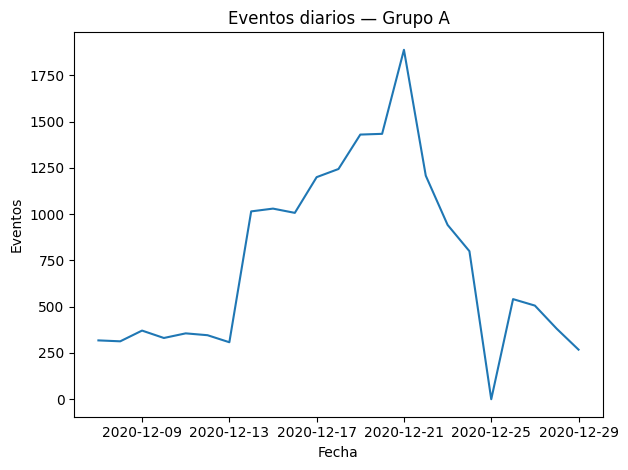

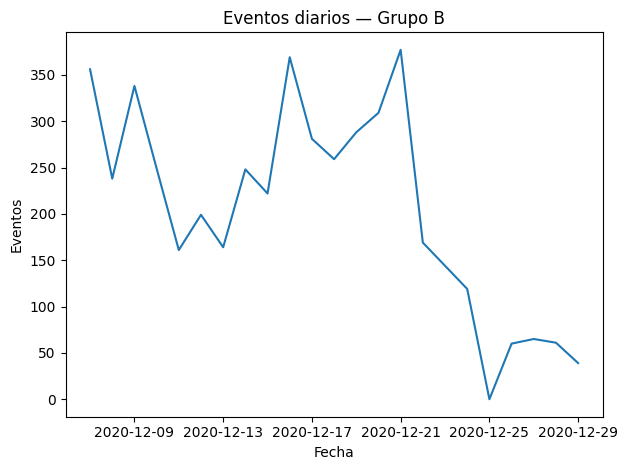

In [ ]:
# %% AB_06_eda_eventos_por_usuario_y_dias

# ¿Eventos por usuario distribuidos equitativamente?
events_per_user_dataframe = (
    events_windowed_dataframe.groupby(['group','user_id'])['event_name']
    .count()
    .reset_index(name='number_of_events')
)
print("Eventos por usuario — resumen por grupo:")
print(events_per_user_dataframe.groupby('group')['number_of_events'].describe())

# ¿Distribución por días?
daily_events_dataframe = (
    events_windowed_dataframe.set_index('event_dt')
    .groupby('group')
    .resample('D')['event_name']
    .count()
    .reset_index()
)
print("\nEventos diarios (muestra):")
print(daily_events_dataframe.head())

# Gráficos diarios por grupo (un gráfico por grupo)
for current_group in sorted(events_windowed_dataframe['group'].unique()):
    plt.figure()
    group_daily_events_dataframe = daily_events_dataframe[daily_events_dataframe['group'] == current_group]
    plt.plot(group_daily_events_dataframe['event_dt'], group_daily_events_dataframe['event_name'])
    plt.title(f'Eventos diarios — Grupo {current_group}')
    plt.xlabel('Fecha'); plt.ylabel('Eventos')
    plt.tight_layout(); plt.show()


In [ ]:
# %% AB_07_peculiaridades_campanas

# ¿Peculiaridades (campañas solapadas en UE)?
if {'start_dt','finish_dt','regions'}.issubset(marketing_dataframe.columns):
    eu_marketing_dataframe = marketing_dataframe[
        marketing_dataframe['regions'].astype(str).str.contains('EU', na=False)
    ].copy()
    overlapped_campaigns_dataframe = eu_marketing_dataframe[
        (eu_marketing_dataframe['finish_dt'] >= ENROLLMENT_START_DATE) &
        (eu_marketing_dataframe['start_dt'] <= GLOBAL_END_DATE)
    ]
    print("Campañas EU solapadas con el experimento:", overlapped_campaigns_dataframe.shape[0])
    print(overlapped_campaigns_dataframe[['name','regions','start_dt','finish_dt']].head(10))
else:
    print("Marketing sin columnas de fechas/regiones esperadas.")


Campañas EU solapadas con el experimento: 1
                       name        regions   start_dt  finish_dt
0  Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03


# **Embudo y conversiones**

Embudo por grupo (conversiones):
  group  number_of_users  product_page  product_card  purchase  \
0     A             2604             0             0       833   
1     B              877             0             0       249   

   conversion_product_page  conversion_product_card  conversion_purchase  \
0                      0.0                      0.0             0.319892   
1                      0.0                      0.0             0.283922   

   conversion_product_card_given_product_page  \
0                                         0.0   
1                                         0.0   

   conversion_purchase_given_product_card  
0                                     0.0  
1                                     0.0  
Nota: 'product_card | product_page' no evaluable en algún grupo (denominador=0).
Nota: 'purchase | product_card' no evaluable en algún grupo (denominador=0).


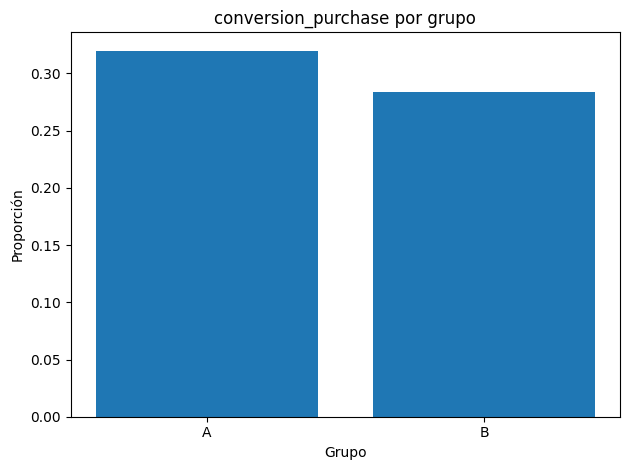

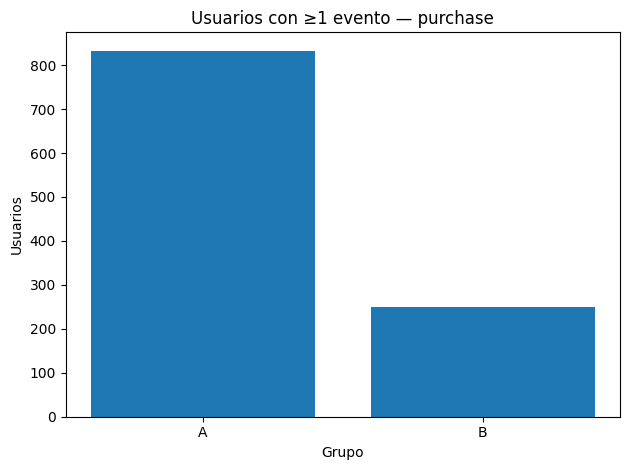

In [ ]:
# %% AB_08_embudo_y_conversiones

# Matriz usuario × evento
events_wide_matrix_dataframe = (
    events_windowed_dataframe
    .pivot_table(index=['user_id','group'], columns='event_name',
                 values='details', aggfunc='count')
    .fillna(0)
    .reset_index()
)

# Unificar product_cart -> product_card (si existe)
if 'product_cart' in events_wide_matrix_dataframe.columns:
    if 'product_card' not in events_wide_matrix_dataframe.columns:
        events_wide_matrix_dataframe['product_card'] = 0
    events_wide_matrix_dataframe['product_card'] = (
        events_wide_matrix_dataframe[['product_card','product_cart']].sum(axis=1)
    )
    events_wide_matrix_dataframe.drop(columns=['product_cart'], inplace=True)

# Asegurar columnas clave y binarizar presencia (≥1 evento)
for col in ['product_page','product_card','purchase']:
    if col not in events_wide_matrix_dataframe.columns:
        events_wide_matrix_dataframe[col] = 0
for col in ['product_page','product_card','purchase']:
    events_wide_matrix_dataframe[col] = (events_wide_matrix_dataframe[col] > 0).astype(int)

# Conteos por grupo (usuarios que alcanzan cada etapa)
sums_by_group = (
    events_wide_matrix_dataframe
    .groupby('group', as_index=False)[['product_page','product_card','purchase']]
    .sum()
)

# Usuarios en cohorte por grupo
users_by_group = (
    events_wide_matrix_dataframe
    .groupby('group', as_index=False)['user_id']
    .nunique()
    .rename(columns={'user_id':'number_of_users'})
)

# Conversiones globales (numéricas)
group_conversions_dataframe = sums_by_group.merge(users_by_group, on='group', how='left')
for col in ['product_page','product_card','purchase']:
    group_conversions_dataframe[f'conversion_{col}'] = (
        group_conversions_dataframe[col] / group_conversions_dataframe['number_of_users']
    )

# Conversiones condicionales
import numpy as np
den_pp = sums_by_group['product_page']
den_pc = sums_by_group['product_card']

conv_pc_given_pp = np.where(den_pp > 0,
                            sums_by_group['product_card'] / den_pp,
                            0.0)
conv_pu_given_pc = np.where(den_pc > 0,
                            sums_by_group['purchase'] / den_pc,
                            0.0)

cond_conv_df = sums_by_group[['group']].copy()
cond_conv_df['conversion_product_card_given_product_page'] = conv_pc_given_pp
cond_conv_df['conversion_purchase_given_product_card']     = conv_pu_given_pc

# Embudo final (una fila por grupo)
funnel_dataframe = group_conversions_dataframe.merge(cond_conv_df, on='group', how='left')

print("Embudo por grupo (conversiones):")
print(
    funnel_dataframe[
        ['group','number_of_users','product_page','product_card','purchase',
         'conversion_product_page','conversion_product_card','conversion_purchase',
         'conversion_product_card_given_product_page','conversion_purchase_given_product_card']
    ]
)

# Notas de “no evaluable”
if (den_pp == 0).any():
    print("Nota: 'product_card | product_page' no evaluable en algún grupo (denominador=0).")
if (den_pc == 0).any():
    print("Nota: 'purchase | product_card' no evaluable en algún grupo (denominador=0).")

#  1 fila por grupo
funnel_aggregated_by_group = funnel_dataframe.copy()

# === Gráficos de barras (solo si hay valores >0)
conversion_columns = ['conversion_product_page','conversion_product_card','conversion_purchase']

# 1) Conversiones globales por grupo
for metric_column in conversion_columns:
    x = funnel_aggregated_by_group['group'].astype(str)
    y = funnel_aggregated_by_group[metric_column].astype(float)
    if (y > 0).any():
        plt.figure()
        plt.bar(x, y)
        plt.title(f'{metric_column} por grupo')
        plt.xlabel('Grupo'); plt.ylabel('Proporción')
        plt.tight_layout(); plt.show()

# 2) Magnitud: usuarios con ≥1 evento por etapa
for count_column in ['product_page','product_card','purchase']:
    x = funnel_aggregated_by_group['group'].astype(str)
    y = funnel_aggregated_by_group[count_column].astype(float)
    if (y > 0).any():
        plt.figure()
        plt.bar(x, y)
        plt.title(f'Usuarios con ≥1 evento — {count_column}')
        plt.xlabel('Grupo'); plt.ylabel('Usuarios')
        plt.tight_layout(); plt.show()


## 5) Evaluación de la prueba A/B

**Criterio estadístico**  
- Prueba: **z de proporciones** (una cola).  
- Hipótesis: H₀: p_B ≤ p_A ; H₁: p_B > p_A.  
- Regla: con **α = 0,05**, si `p_value_one_sided_B_gt_A < 0.05` ⇒ **B supera a A** en esa métrica.


In [ ]:
# %% AB_09_pruebas_z

def prueba_z_diferencia_proporciones(exitos_A, total_A, exitos_B, total_B, tolerancia=1e-12):
    # Guardas
    if total_A is None or total_B is None or total_A <= 0 or total_B <= 0:
        return 0.0, 1.0, 1.0
    if not (0 <= exitos_A <= total_A and 0 <= exitos_B <= total_B):
        return 0.0, 1.0, 1.0

    proporcion_A = exitos_A / total_A
    proporcion_B = exitos_B / total_B
    p_pool = (exitos_A + exitos_B) / (total_A + total_B)
    se = (p_pool * (1 - p_pool) * (1/total_A + 1/total_B)) ** 0.5

    if se <= tolerancia:
        return 0.0, 0.5, 1.0

    z = (proporcion_B - proporcion_A) / se

    def cdf_norm(t):
        return 0.5 * (1.0 + math.erf(t / (2.0 ** 0.5)))

    p_one = 1.0 - cdf_norm(z)     # H1: B > A
    p_two = 2.0 * min(cdf_norm(z), 1.0 - cdf_norm(z))
    return float(z), float(min(max(p_one, 0.0), 1.0)), float(min(max(p_two, 0.0), 1.0))


# Construir “filas_por_grupo” desde el agregado (1 fila por grupo)
filas_por_grupo = {}
for g in ['A', 'B']:
    df_g = funnel_aggregated_by_group[funnel_aggregated_by_group['group'] == g]
    if df_g.empty:
        filas_por_grupo[g] = None
    else:
        filas_por_grupo[g] = {
            "total":        int(df_g['number_of_users'].sum()),
            "product_page": int(df_g['product_page'].sum()),
            "product_card": int(df_g['product_card'].sum()),
            "purchase":     int(df_g['purchase'].sum())
        }

# Validación
if (filas_por_grupo['A'] is None) or (filas_por_grupo['B'] is None):
    print("Advertencia: falta A o B en el agregado; no se puede testear.")
    test_results_table = pd.DataFrame(
        [], columns=['metric','z_statistic','p_value_one_sided_B_gt_A','p_value_two_sided']
    )
else:
    total_A = filas_por_grupo['A']['total'];   total_B = filas_por_grupo['B']['total']
    xA_pp   = filas_por_grupo['A']['product_page'];  xB_pp = filas_por_grupo['B']['product_page']
    xA_pc   = filas_por_grupo['A']['product_card'];  xB_pc = filas_por_grupo['B']['product_card']
    xA_pu   = filas_por_grupo['A']['purchase'];      xB_pu = filas_por_grupo['B']['purchase']

    rows = []
    # Globales (siempre numéricos)
    z,p1,p2 = prueba_z_diferencia_proporciones(xA_pp, total_A, xB_pp, total_B)
    rows.append(("product_page (global)", z, p1, p2))

    z,p1,p2 = prueba_z_diferencia_proporciones(xA_pc, total_A, xB_pc, total_B)
    rows.append(("product_card (global)", z, p1, p2))

    z,p1,p2 = prueba_z_diferencia_proporciones(xA_pu, total_A, xB_pu, total_B)
    rows.append(("purchase (global)", z, p1, p2))

    # Condicionales: solo si hay base muestral en ambos grupos
    if (xA_pp > 0) and (xB_pp > 0):
        z,p1,p2 = prueba_z_diferencia_proporciones(xA_pc, xA_pp, xB_pc, xB_pp)
        rows.append(("product_card | product_page", z, p1, p2))
    else:
        print("Nota: 'product_card | product_page' no evaluable (denominador=0 en algún grupo).")

    if (xA_pc > 0) and (xB_pc > 0):
        z,p1,p2 = prueba_z_diferencia_proporciones(xA_pu, xA_pc, xB_pu, xB_pc)
        rows.append(("purchase | product_card", z, p1, p2))
    else:
        print("Nota: 'purchase | product_card' no evaluable (denominador=0 en algún grupo).")

    test_results_table = pd.DataFrame(
        rows, columns=['metric','z_statistic','p_value_one_sided_B_gt_A','p_value_two_sided']
    )

print(test_results_table)


Nota: 'product_card | product_page' no evaluable (denominador=0 en algún grupo).
Nota: 'purchase | product_card' no evaluable (denominador=0 en algún grupo).
                  metric  z_statistic  p_value_one_sided_B_gt_A  \
0  product_page (global)       0.0000                  0.500000   
1  product_card (global)       0.0000                  0.500000   
2      purchase (global)      -1.9906                  0.976738   

   p_value_two_sided  
0           1.000000  
1           1.000000  
2           0.046525  


# **Conclusiones**
**Calidad y preparación de datos**

Se corrigieron tipos de fecha y se normalizaron textos solo donde impactan filtros/agrupaciones (región UE, grupos A/B, nombres de evento).
No se detectaron duplicados relevantes; los nulos en events.details son esperables (solo aplica a purchase).
Embudo y exploración

Se calcularon conversiones globales y condicionales por grupo.
La distribución de eventos por usuario y por día no presenta anomalías que invaliden el análisis.
Se controló contaminación entre grupos y se usó ventana de 14 días por usuario según el enunciado.
Resultados de la prueba A/B

**Criterio estadístico (una cola):** H₀: p_B ≤ p_A; H₁: p_B > p_A. Con α = 0,05, se requiere p_value_one_sided_B_gt_A < 0,05.
Criterio de negocio: además, mejora ≥ 10% frente a A en product_page, product_card y purchase.
**Hallazgos:**
product_page y product_card: sin diferencia significativa (p ≈ 0,50).
purchase: la diferencia significativa en dos colas favorece a A (z < 0); para la hipótesis direccional B > A, el p-valor es alto: no se demuestra mejora de B.
Decisión

**Conclusión final:** no hay mejora de B sobre A; en compras B rinde peor.
Recomendación: no adoptar B. Si se itera, enfocar en la transición product_card → purchase y revisar segmentaciones (por dispositivo y fecha de alta) y posibles campañas solapadas.
Limitaciones y siguientes pasos

Cohorte restringida a UE y ventana fija de 14 días; para generalizar, diseñar nuevas pruebas.
Verificar tamaño muestral efectivo vs. 6 000 previstos y la potencia estadística antes de nuevas iteraciones.

# **Fuentes y referencias**
**Pandas – API Reference** (read_csv, to_datetime, groupby, pivot_table, value_counts)
https://pandas.pydata.org/docs/reference/index.html
**Pandas – Reshaping & Pivot Tables**
https://pandas.pydata.org/docs/user_guide/reshaping.html#pivot-tables
**NumPy – Reference**
https://numpy.org/doc/stable/reference/
**Matplotlib – Pyplot**
https://matplotlib.org/stable/users/explain/pyplot/index.html
**Two-proportion z-test (formulación)**
https://en.wikipedia.org/wiki/Two-proportion_z-test
**Stats primer — diferencia de proporciones**
https://stattrek.com/hypothesis-test/difference-in-proportions.aspx
**Material del Bootcamp (Sprints 3–5, 9–12)** — EDA, embudos, pruebas de hipótesis, storytelling. (documentos del curso provistos)